# v3
    1、使用 Data augmentation 生成資料，增加普適性 (泛化性)
    2、learning rate 設計

In [0]:
!pip install efficientnet

In [0]:
%tensorflow_version 2.x
import zipfile
import os
import csv
import numpy as np
import shutil
from tqdm.auto import tqdm

# 載入資料

In [0]:
IMAGE_SIZE = 256
BATCH_SIZE = 16
STEPS = 64
NUM_EPOCHS = 40
NUM_CLASSES = 3
DATASET_PATH = '/content/C1-P1_Train_Dev/C1-P1/'       # 資料路徑

In [0]:
def image_class():
    train_test_split = 0.2

    f = zipfile.ZipFile("/content/drive/My Drive/Colab Notebooks/AIMango_sample/C1-P1_Train_Dev.zip")
    f.extractall("./")

    # 依分類建立資料夾
    if not os.path.isdir(DATASET_PATH + 'train'):
        os.mkdir(DATASET_PATH + 'train')
    if not os.path.isdir(DATASET_PATH + 'test'):
        os.mkdir(DATASET_PATH + 'test')
    if not os.path.isdir(DATASET_PATH + 'train/A'):
        os.mkdir(DATASET_PATH + 'train/A')
    if not os.path.isdir(DATASET_PATH + 'train/B'):
        os.mkdir(DATASET_PATH + 'train/B')
    if not os.path.isdir(DATASET_PATH + 'train/C'):
        os.mkdir(DATASET_PATH + 'train/C')
    if not os.path.isdir(DATASET_PATH + 'test/A'):
        os.mkdir(DATASET_PATH + 'test/A')
    if not os.path.isdir(DATASET_PATH + 'test/B'):
        os.mkdir(DATASET_PATH + 'test/B')
    if not os.path.isdir(DATASET_PATH + 'test/C'):
        os.mkdir(DATASET_PATH + 'test/C')
    
    with open('/content/C1-P1_Train_Dev/C1-P1.csv') as csvfile:
        rows = csv.reader(csvfile)

        level_path = {'A': [], 'B': [], 'C': []}
        for row in rows:
            level_path[row[1][-1]].append(DATASET_PATH + row[0])

        for lvl in level_path:            
            count = int(len(level_path[lvl]) * (1 - train_test_split))
            for i, img_path in enumerate(tqdm(level_path[lvl])):
                if i < count:
                    shutil.move(img_path, DATASET_PATH + 'train/' + lvl)
                else:
                    shutil.move(img_path, DATASET_PATH + 'test/' + lvl)

image_class()

# 資料增強 ImageDataGenerator

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

trn_dagen = ImageDataGenerator(rescale= 1. / 255,
                               rotation_range=40,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               channel_shift_range=10,
                               horizontal_flip=True,
                               fill_mode='nearest',
                               dtype='float32')

val_dagen = ImageDataGenerator(rescale= 1./ 255,
                               validation_split=0.2,
                               dtype='float32')

trn_gen = trn_dagen.flow_from_directory(DATASET_PATH + 'train',
                                        target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical',
                                        shuffle=True,
                                        subset='training')

val_gen = val_dagen.flow_from_directory(DATASET_PATH + 'train',
                                        target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical',
                                        shuffle=True,
                                        subset='validation')

Found 5119 images belonging to 3 classes.
Found 1022 images belonging to 3 classes.


# 動態設計 Learning rate

Learning rate schedule: 0.0001 to 0.0001 to 9.99e-05


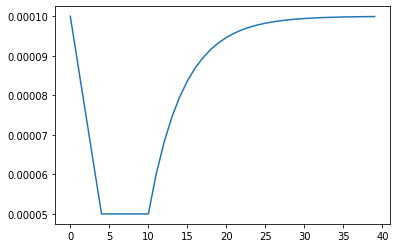

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt

LR_START = 0.0001
LR_MAX = 0.00005
LR_MIN = 0.0001
LR_RAMPUP_EPOCHS = 4
LR_SUSTAIN_EPOCHS = 6
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(NUM_EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# CNN、FC 模型建立

In [0]:
import efficientnet.tfkeras as efn
from tensorflow.keras import Model
import tensorflow.keras.layers as L

net = efn.EfficientNetB7(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                         weights='noisy-student',
                         include_top=False)

x = net.output
x = L.Flatten()(x)
x = L.Dropout(0.5)(x)
x = L.Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=net.input, outputs=x)

258072576/258068648 [==============================] - 7s 0us/step


# 模型編譯 optimizer、loss、metrics

In [0]:
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa

model.compile(optimizer=Adam(learning_rate=1e-3, amsgrad=True),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

# 模型訓練

In [0]:
history = model.fit(trn_gen,
                    steps_per_epoch=trn_gen.samples // STEPS,
                    epochs=NUM_EPOCHS, verbose=2,
                    callbacks=[lr_callback],
                    validation_data=val_gen,
                    validation_steps=val_gen.samples // STEPS)

# Plot accuracy

Text(0.5, 1.0, 'acc')

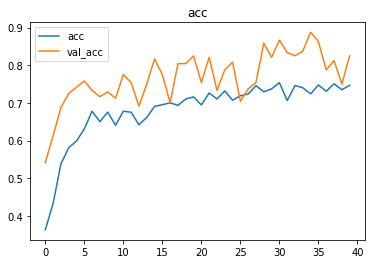

In [0]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.legend(['acc', 'val_acc'])
plt.title('acc')

# Plot loss 

Text(0.5, 1.0, 'loss')

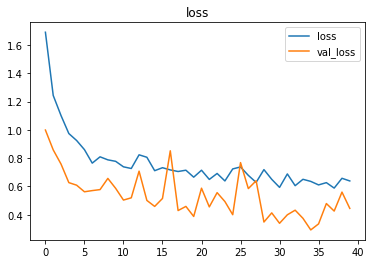

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')

# 評估模型

In [0]:
gobj = ImageDataGenerator(rescale=1./255, dtype='float32')

eva_gen = gobj.flow_from_directory(DATASET_PATH + 'test',
                                   target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                   batch_size=BATCH_SIZE,
                                   class_mode='categorical')

loss, acc = model.evaluate(eva_gen, steps=STEPS)
print('評估的準確率: ', acc)

Found 1281 images belonging to 3 classes.
64/64 [==============================] - 16s 253ms/step - loss: 0.6292 - categorical_accuracy: 0.7783
評估的準確率:  0.7783203125


In [0]:
pre_gen = gobj.flow_from_directory(DATASET_PATH + 'test',
                                   target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                   batch_size=10,
                                   class_mode=None)
ans = model.predict(pre_gen, steps=1)
print('預測的結果: ', ans.round(1))

Found 1281 images belonging to 3 classes.
預測的結果:  [[0.1 0.9 0. ]
 [0.  1.  0. ]
 [0.6 0.4 0. ]
 [0.1 0.3 0.6]
 [0.8 0.2 0. ]
 [0.1 0.9 0. ]
 [0.  0.5 0.4]
 [0.  1.  0. ]
 [0.6 0.4 0. ]
 [0.4 0.6 0. ]
 [0.3 0.7 0. ]
 [0.7 0.3 0. ]
 [0.9 0.1 0. ]
 [0.7 0.3 0. ]
 [0.2 0.8 0. ]
 [0.3 0.7 0. ]]
